# Coursework Template

**Dependencies and imports**

This can take a minute...

In [11]:
# !pip install swig
# !pip install --upgrade rldurham

In [12]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [13]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Agent, self).__init__()
        
        # Initialize networks with orthogonal weights for better gradient flow
        self.policy = self._build_policy_network(state_dim, action_dim, hidden_dim)
        self.value = self._build_value_network(state_dim, hidden_dim)
        
        # Hyperparameters tuned for stability
        self.gamma = 0.99
        self.learning_rate = 3e-4
        self.gae_lambda = 0.95
        self.clip_ratio = 0.2
        self.entropy_coef = 0.01  # Encourage exploration
        self.value_coef = 0.5    # Balance value and policy learning
        
        # Adaptive noise control
        self.init_action_std = 0.5
        self.action_std = self.init_action_std
        self.action_std_decay = 0.995
        self.min_action_std = 0.1
        self.noise_decay_start = 100  # Start decay after 100 episodes
        
        # Experience management
        self.trajectory = []
        self.value_normalizer = RunningMeanStd()
        self.state_normalizer = RunningMeanStd(shape=state_dim)
        
        # Optimization
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Statistics tracking
        self.running_rewards = deque(maxlen=100)
        self.episode_count = 0
        self.best_reward = float('-inf')
        self.recent_actions = deque(maxlen=5)  # For action smoothing
        
    def _build_policy_network(self, state_dim, action_dim, hidden_dim):
        """Build policy network with proper initialization"""
        policy = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )
        
        # Orthogonal initialization for better training dynamics
        for layer in policy:
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
                torch.nn.init.zeros_(layer.bias)
        
        return policy
    
    def _build_value_network(self, state_dim, hidden_dim):
        """Build value network with proper initialization"""
        value = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        for layer in value:
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
                torch.nn.init.zeros_(layer.bias)
        
        return value
    
    def normalize_state(self, state):
        """Normalize state using running statistics"""
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
        return torch.FloatTensor(self.state_normalizer(state.numpy()))
    
    def sample_action(self, state):
        """Sample action with adaptive noise and temporal smoothing"""
        state = self.normalize_state(state)
        
        with torch.no_grad():
            mean_action = self.policy(state)
            
            # Add exploration noise with adaptive standard deviation
            noise = torch.randn_like(mean_action) * self.action_std
            action = torch.clamp(mean_action + noise, -1, 1)
            
            # Apply temporal smoothing for more natural movements
            if len(self.recent_actions) > 0:
                smooth_factor = 0.7
                prev_action = np.mean([a for a in self.recent_actions], axis=0)
                action = smooth_factor * action + (1 - smooth_factor) * torch.FloatTensor(prev_action)
            
            self.recent_actions.append(action.numpy())
        
        return action.numpy()
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition with normalized states"""
        state = self.normalize_state(state)
        next_state = self.normalize_state(next_state)
        self.trajectory.append((state, action, reward, next_state, done))
    
    def train(self):
        """Update policy and value networks with improved stability measures"""
        if len(self.trajectory) < 1:
            return 0, 0
        
        states, actions, rewards, next_states, dones = zip(*self.trajectory)
        
        # Convert to tensors
        states = torch.stack(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute normalized returns and advantages
        with torch.no_grad():
            values = self.value(states).squeeze()
            next_values = self.value(next_states).squeeze()
            
            # Compute GAE
            advantages = torch.zeros_like(rewards)
            gae = 0
            for t in reversed(range(len(rewards))):
                if t == len(rewards) - 1:
                    next_value = next_values[t]
                else:
                    next_value = values[t + 1]
                
                delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
                gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
                advantages[t] = gae
            
            returns = advantages + values
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute action probabilities
        mean_actions = self.policy(states)
        dist = torch.distributions.Normal(mean_actions, self.action_std)
        old_log_probs = dist.log_prob(actions).sum(dim=1)
        
        # Multiple epochs of optimization for better sample efficiency
        for _ in range(4):
            # Compute new action probabilities
            mean_actions = self.policy(states)
            dist = torch.distributions.Normal(mean_actions, self.action_std)
            new_log_probs = dist.log_prob(actions).sum(dim=1)
            
            # Compute entropy for exploration
            entropy = dist.entropy().mean()
            
            # Compute policy loss with clipping
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Compute value loss
            value_pred = self.value(states).squeeze()
            value_loss = F.mse_loss(value_pred, returns.detach())
            
            # Combined loss with entropy bonus
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
            
            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)
            self.optimizer.step()
        
        # Clear trajectory buffer
        self.trajectory = []
        
        # Update exploration noise
        if self.episode_count > self.noise_decay_start:
            self.action_std = max(self.min_action_std, 
                                self.action_std * self.action_std_decay)
        
        return policy_loss.item(), value_loss.item()
    
    def update_stats(self, episode_reward):
        """Update running statistics and episode count"""
        self.running_rewards.append(episode_reward)
        self.episode_count += 1
        self.best_reward = max(self.best_reward, episode_reward)
    
    def get_average_reward(self):
        """Calculate average reward over last 100 episodes"""
        return np.mean(self.running_rewards) if self.running_rewards else 0
    
    def reset(self):
        """Reset temporal smoothing between episodes"""
        self.recent_actions.clear()

class RunningMeanStd:
    """Tracks running mean and standard deviation for normalization"""
    def __init__(self, shape=(), epsilon=1e-4):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = epsilon
        
    def __call__(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0] if len(x.shape) > 1 else 1
        
        delta = batch_mean - self.mean
        self.mean += delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        self.var = M2 / (self.count + batch_count)
        self.count += batch_count
        
        return (x - self.mean) / np.sqrt(self.var + 1e-8)

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


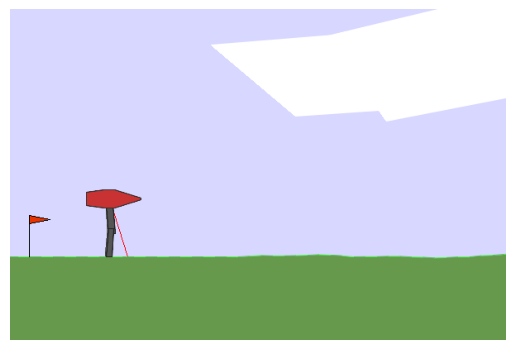

In [14]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

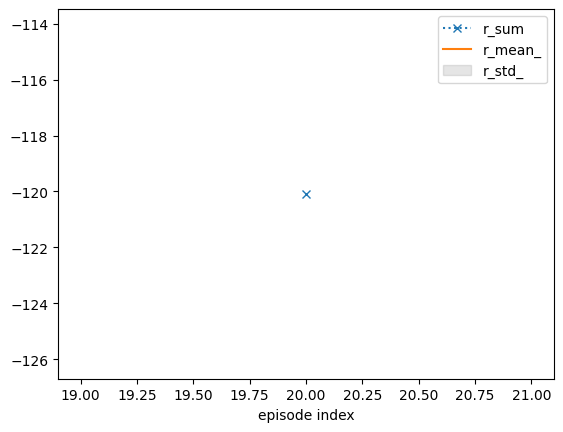

In [15]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 100
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

for episode in range(max_episodes):
    # Set up episode
    env.info = episode % 10 == 0
    env.video = episode % 10 == 0
    current_observation, info = env.reset()
    episode_reward = 0
    
    # Reset agent's temporal smoothing
    agent.reset()
    
    # Run episode
    for t in range(max_timesteps):
        # Get action from agent
        action = agent.sample_action(current_observation)
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition and update episode reward
        agent.put_data(current_observation, action, reward, next_observation, 
                      terminated or truncated)
        episode_reward += reward
        
        # Update observation
        current_observation = next_observation
        
        # Check if episode is done
        if terminated or truncated:
            break
    
    # Train agent and update statistics
    policy_loss, value_loss = agent.train()
    agent.update_stats(episode_reward)
    
    # Print progress every 10 episodes
    if episode % 10 == 0:
        avg_reward = agent.get_average_reward()
        print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
              f"Avg Reward: {avg_reward:.2f}, "
              f"Action STD: {agent.action_std:.3f}")
    
    # Track and plot
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

env.close()

# Write log file
env.write_log(folder="logs", file="xxxx00-agent-log.txt")

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [16]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
